# Introduction

Google colab環境で簡単に実行したい場合は以下をクリック↓

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RIPES-ACROSS/Control-System-Design-and-Application/blob/master/11_Design_by_Frequency_Response/frequency_resnponse.ipynb)

## 制御モジュールのインストール

In [1]:
! pip install control

## モジュールの読み込み

In [2]:
from pylab import *
import math
import cmath
import numpy as np
import pandas as pd
import control
import control.matlab as matlab
import matplotlib.pyplot as plt
%matplotlib inline

## 複素数の定義

In [3]:
s = matlab.TransferFunction.s

## 対象とする系

ユニティーフィードバック系における前向きの伝達関数は次の通り与えられる．
\begin{align}
G(s) = \frac{100K}{s(s+36)(s+100)}
\end{align}

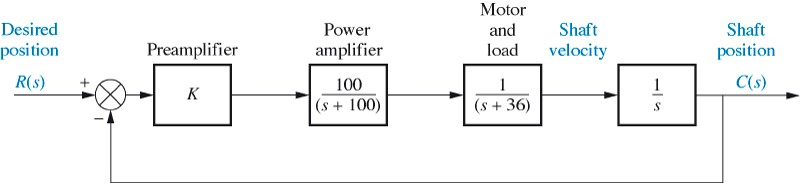

In [4]:
from IPython.display import Image
Image("model.jpg")

## 伝達関数の定義

In [5]:
G_without_gainK = 100 / (s*(s+36)*(s+100))

G_without_gainK

TransferFunction(array([100]), array([   1,  136, 3600,    0]))

### %OSから$\zeta$を導出する関数の定義

In [6]:
def zeta_from_pos(pos):
    zeta = -1*math.log(pos/100) / math.sqrt(math.pi**2 + math.log(pos/100)**2)
    return zeta

### $\zeta$から位相余裕を導出する関数の定義

In [7]:
def phim_from_zeta(zeta):
    phim = math.atan(2*zeta/math.sqrt(-2* zeta**2 + math.sqrt(1+4* zeta**4)))
    return np.rad2deg(phim)

### ステップ応答を可視化する関数の定義

In [8]:
def visualize_step(sys_dict):
    TIME_MAX = 20

    fig = plt.figure(figsize=(6,5))
    ax = fig.add_subplot(1, 1, 1)
    plt.plot(list(np.arange(-10, 0+1))+list(np.arange(1, TIME_MAX+1)), 
             [0]*len(np.arange(-10, 0+1))+[1]*len(np.arange(1, TIME_MAX+1)), 
             '-.', color='gray', drawstyle='steps-pre', label='Step input')
    for i, (label, sys) in enumerate(sys_dict.items()):
        output, time_list = matlab.step(sys, arange(0, TIME_MAX, 0.1))

        plt.plot(time_list, output, '--',
                 label=label, linewidth=3.0/(i+1))

    #plt.xlim(-1, TIME_MAX)
    #plt.ylim(-0.2, 1.2)
    plt.xlabel('Time  second')
    plt.ylabel('Response  p.u.')
    plt.grid()
    plt.legend(framealpha=0.1)
    plt.show()

### ボード線図を描画する関数の定義

In [9]:
def visualize_bode(sys_dict):
    res_dict = {}
    for label, sys in sys_dict.items():
        mag, phase, omega = control.bode(sys, dB=True, label=label)
        tmp_df = pd.DataFrame(np.array([np.rad2deg(phase), 
                                        list(map(lambda v: 20*math.log10(v), mag))]).T,
            index=omega, columns=['phase', 'mag'])
        tmp_df.index.name = 'omega'
        res_dict[label] = tmp_df.copy()
    plt.legend()
    plt.show()
    
    return res_dict

### 根軌跡を描画する関数の定義

In [10]:
def _make_rklist(sys):
    rlist, klist = \
        matlab.rlocus(sys, 
                      #xlim=[-5, 2], ylim=[-5, 5],
                      kvect=np.arange(0, 1e+1+2, 1e-1), # [TODO] need to automatically adjustment for list of gains
                      grid=True,
                      plot=False
                    )
    return (rlist, klist)

def _make_df(rklist):
    rlist = rklist[0]
    klist = rklist[1]
    df = pd.DataFrame(rlist, index=klist)
    df.index.name = 'K'
    df.columns = list(map(lambda i: f'Pole-{i}' , np.arange(1, len(rlist[0])+1)))
    return df

def _visualize_rl(df):
    for label, sys in sys_dict.items():
        fig = plt.figure(figsize=(6,5))
        ax = fig.add_subplot(1, 1, 1)
        for i, col in enumerate(df.columns.tolist()):
            plt.plot(df.iloc[0, i].real, df.iloc[0, i].imag,
                     marker='x', color='black', markersize=10)
            plt.plot(df.iloc[:, i].to_numpy().real, df.iloc[:, i].to_numpy().imag, '--',
                     label=r'{} $\sigma=${}'.format(col, round(df.iloc[0, i].real,2)))
        plt.xlabel('Real')
        plt.ylabel('Imaginary')
        plt.grid()
        plt.legend(framealpha=0.1)
        plt.show()    

def visualize_rl(sys_dict):
    for label, sys in sys_dict.items():
        print(label)
        _visualize_rl(_make_df(_make_rklist(sys)))

# ゲイン補償による設計

## 問1 

%オーバーシュートを9.5にするゲイン$K$を見つけよ

### 準備

根軌跡を眺めて，5倍ルールによる2次系への近似が妥当であることを確認する

TransferFunction(array([360.]), array([   1,  136, 3600,    0]))

K: 3.6


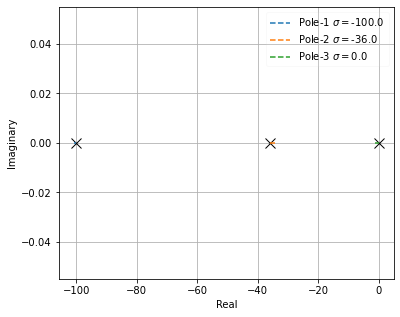

In [11]:
sys_dict = {}
for K in [3.6]:
    sys_dict[f'K: {K}'] = G_without_gainK*K
    display(sys_dict[list(sys_dict.keys())[-1]])
visualize_rl(sys_dict)

#### 解答1
仮にゲインK=3.6として挙動を図示する

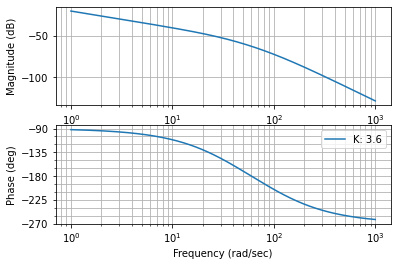

,phase,mag
omega,,
1.000000,-92.164079,-20.003784
1.006939,-92.179089,-20.063897
1.013925,-92.194202,-20.124010
1.020961,-92.209421,-20.184124
1.028045,-92.224745,-20.244239


,phase,mag
omega,,
972.720319,-262.010831,-128.204832
979.469667,-262.065590,-128.384307
986.265846,-262.119978,-128.563792
993.109181,-262.173997,-128.743285
1000.000000,-262.227649,-128.922789


In [12]:
res_dict = visualize_bode(sys_dict)
display(res_dict['K: 3.6'].head(), res_dict['K: 3.6'].tail())

2次系の場合の$\zeta$と%OSの関係式から，$\zeta$を求める

In [13]:
pos_1 = 9.5
zeta_1 = zeta_from_pos(pos_1)

round(zeta_1, 3)

0.6

### 問2 その際の位相余裕は?

### 解答2

2次系の場合の位相余裕と$zeta$の関係式から，$\zeta$を求める

In [14]:
phim_1 = phim_from_zeta(zeta_1)

round(phim_1, 3)

59.162

### 問3 その際の位相交差周波数は?

### 解答3

ボード線図から読み取る

In [15]:
phi_pos95 = -1*(180 - phim_1)

round(phi_pos95, 3)

-120.838

In [16]:
tmp_df = res_dict['K: 3.6']
EPSILON = 1e-1
target_record = tmp_df[(phi_pos95 - EPSILON <= tmp_df.phase) \
                        & (tmp_df.phase <= phi_pos95 + EPSILON)]

target_omega = target_record.index.values[0]
target_mag = target_record.mag.values[0]
display(target_record, round(target_omega, 3), round(target_mag, 3))

,phase,mag
omega,,
14.831025,-120.826392,-44.198741


14.831

-44.199

### 問4 仕様を満たすゲイン$K$の範囲は?

### 解答4

マグニチュードは0 dbまであと44 db上げることが出来る．
14 rad/sの際に0 dbに近づくように，$K$を3.6から大きくする方向へ探索する

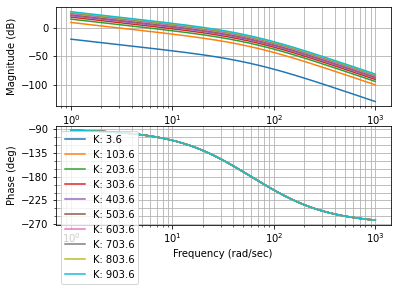

In [17]:
sys_dict = {}
for K in np.arange(3.6, 1e+3, 1e+2):
    sys_dict[f'K: {K}'] = G_without_gainK*K    
res_dict = visualize_bode(sys_dict)

In [18]:
EPSILON = 1e-1
for label, tmp_df in res_dict.items():
    tmp_record = tmp_df[(target_omega-EPSILON <= tmp_df.index)\
                        & (tmp_df.index <= target_omega+EPSILON)]
    print(label, r', omega: ', tmp_record.index.values[0],
          r', 20logM: ', tmp_record.mag.values[0])

K: 3.6 , omega:  14.831025143361044 , 20logM:  -44.198740509626035
K: 103.6 , omega:  14.831025143361044 , 20logM:  -15.017595416787493
K: 203.6 , omega:  14.831025143361044 , 20logM:  -9.149235051677355
K: 303.6 , omega:  14.831025143361044 , 20logM:  -5.678755180502922
K: 403.6 , omega:  14.831025143361044 , 20logM:  -3.205767373674318
K: 503.6 , omega:  14.831025143361044 , 20logM:  -1.283076096255277
K: 603.6 , omega:  14.831025143361044 , 20logM:  0.29019409709926813
K: 703.6 , omega:  14.831025143361044 , 20logM:  1.6217260907366953
K: 803.6 , omega:  14.831025143361044 , 20logM:  2.7760080365524535
K: 903.6 , omega:  14.831025143361044 , 20logM:  3.79473391999473


K = 600周辺が良さそうだ．

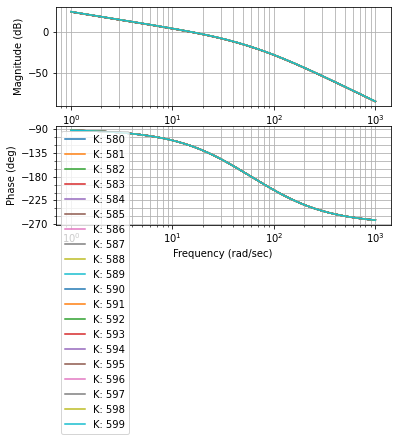

In [19]:
sys_dict = {}
for K in np.arange(580, 600, 1):
    sys_dict[f'K: {K}'] = G_without_gainK*K    
res_dict = visualize_bode(sys_dict)

In [20]:
EPSILON = 1e-1
for label, tmp_df in res_dict.items():
    tmp_record = tmp_df[(target_omega-EPSILON <= tmp_df.index)\
                        & (tmp_df.index <= target_omega+EPSILON)]
    print(label, r', omega: ', tmp_record.index.values[0],
          r', 20logM: ', tmp_record.mag.values[0])

K: 580 , omega:  14.831025143361044 , 20logM:  -0.05623065371303165
K: 581 , omega:  14.831025143361044 , 20logM:  -0.0412678771651621
K: 582 , omega:  14.831025143361044 , 20logM:  -0.026330831974007565
K: 583 , omega:  14.831025143361044 , 20logM:  -0.01141942979149598
K: 584 , omega:  14.831025143361044 , 20logM:  0.0034664172762115695
K: 585 , omega:  14.831025143361044 , 20logM:  0.018326796671832277
K: 586 , omega:  14.831025143361044 , 20logM:  0.03316179539003588
K: 587 , omega:  14.831025143361044 , 20logM:  0.04797149998051384
K: 588 , omega:  14.831025143361044 , 20logM:  0.06275599655099363
K: 589 , omega:  14.831025143361044 , 20logM:  0.07751537077025623
K: 590 , omega:  14.831025143361044 , 20logM:  0.09224970787110676
K: 591 , omega:  14.831025143361044 , 20logM:  0.10695909265332978
K: 592 , omega:  14.831025143361044 , 20logM:  0.12164360948661951
K: 593 , omega:  14.831025143361044 , 20logM:  0.13630334231347563
K: 594 , omega:  14.831025143361044 , 20logM:  0.150938

584が良さそうだ

TransferFunction(array([58390.]), array([   1,  136, 3600,    0]))

TransferFunction(array([360.]), array([   1,  136, 3600,    0]))

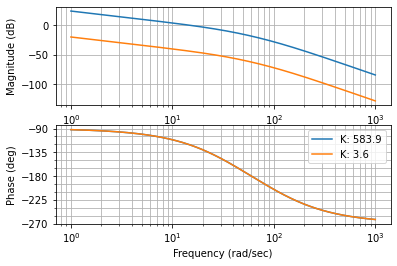

In [21]:
MY_K = 583.9
sys_dict = {}
for K in [MY_K, 3.6]:
    sys_dict[f'K: {K}'] = G_without_gainK*K
    display(sys_dict[list(sys_dict.keys())[-1]])
    
res_dict = visualize_bode(sys_dict)

### ステップ応答の確認

TransferFunction(array([58390.]), array([1.000e+00, 1.360e+02, 3.600e+03, 5.839e+04]))

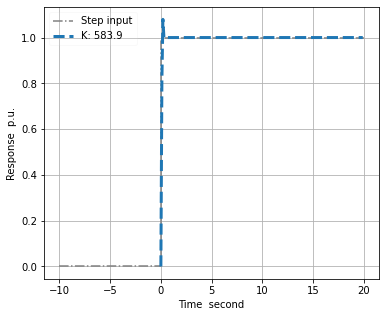

In [22]:
sys_dict = {}
for K in [MY_K]:
    sys_dict[f'K: {K}'] = matlab.feedback(G_without_gainK*K, 1)
    display(sys_dict[list(sys_dict.keys())[-1]])
visualize_step(sys_dict)

# 遅れ補償器による定常偏差の改善

## 伝達関数の設定

In [23]:
K_Q2 = 5839

In [24]:
sys_dict = {}
for K in [K_Q2]:
    sys_dict[f'K: {K}'] = G_without_gainK*K
    display(sys_dict[list(sys_dict.keys())[-1]])

TransferFunction(array([583900]), array([   1,  136, 3600,    0]))

## 問1 %OS 9.5を維持したまま，定常偏差を10%改善せよ

### 解答1

まず，ボード線図を描画する

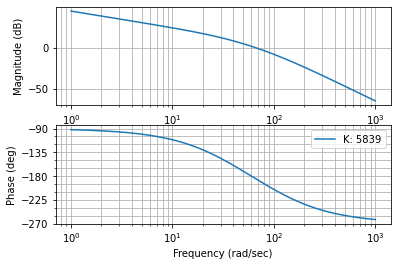

In [25]:
res_dict = visualize_bode(sys_dict)

In [26]:
res_dict['K: 5839'].head()

,phase,mag
omega,,
1.000000,-92.164079,44.196935
1.006939,-92.179089,44.136823
1.013925,-92.194202,44.076709
1.020961,-92.209421,44.016595
1.028045,-92.224745,43.956480


次に，位相余裕が59.2°であったことから，遅れ補償器を用いて10°改善し69.2°にすることを目指す．

In [27]:
target_phase_angle = -1 * (180 - 69.2)

target_phase_angle

-110.8

さらに，-110.8°のときの周波数を探す

In [28]:
EPSILON = 1e-1
for label, tmp_df in res_dict.items():
    tmp_record = tmp_df[(target_phase_angle-EPSILON <= tmp_df.phase)\
                        & (tmp_df.phase <= target_phase_angle+EPSILON)]
    target_omega = tmp_record.index.values[0]
    print(label, r', omega: ', round(target_omega, 3))

K: 5839 , omega:  9.795


周波数9.8 rad/sのときの，現モデルにおけるゲイン余裕を探す．

In [29]:
EPSILON = 1e-1
for label, tmp_df in res_dict.items():
    tmp_record = tmp_df[(target_omega-EPSILON <= tmp_df.index)\
                        & (tmp_df.index <= target_omega+EPSILON)]
    current_mag = tmp_record.mag.values[0]
    print(label, r', 20logM: ', round(current_mag, 3))

K: 5839 , 20logM:  24.094


9.8 rad/s において24 db下げると，次の遅れ補償器を得る

In [30]:
G_c = 0.063*(s+0.98) / (s+0.062)

G_without_gainK*MY_K*G_c

TransferFunction(array([3678.57  , 3604.9986]), array([1.000000e+00, 1.360620e+02, 3.608432e+03, 2.232000e+02,
       0.000000e+00]))

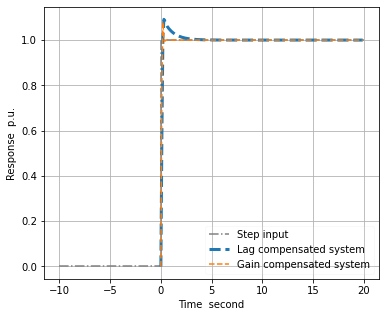

In [31]:
visualize_step({
    'Lag compensated system': matlab.feedback(G_without_gainK*K_Q2*G_c, 1),
    'Gain compensated system': matlab.feedback(G_without_gainK*MY_K, 1),
               })

# 進み補償

補償されていないシステム

In [32]:
G_unconpensated = 100*K / (s*(s+36)*(s+100))

G_unconpensated

TransferFunction(array([583900]), array([   1,  136, 3600,    0]))

## 問1 

%OSが20%となり，$K_v=40$，ピーク時刻が0.1秒となる進み補償器を設計せよ

In [33]:
def omega_bw_from_Tp_zeta(Tp, zeta):
    omega_bw = math.pi/(Tp*math.sqrt(1-zeta**2)) * math.sqrt((1-zeta**2) + math.sqrt(4*zeta**4 -4*zeta**2 + 2))
    return omega_bw

In [34]:
Tp = 0.1
zeta = 0.456 # 20%OS

omega_bw = omega_bw_from_Tp_zeta(Tp, zeta)

omega_bw

49.29533012023451

$K_v$を40にするには，$K$は1440である．

(中略)

In [35]:
G_c_G = 342600*(s+25.3) / (s*(s+36)*(s+100)*(s+60.2))

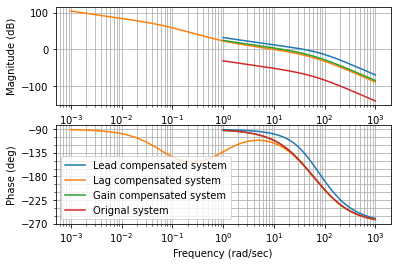

In [36]:
sys_dict = {
    'Lead compensated system': G_c_G,
    'Lag compensated system': G_without_gainK*K_Q2*G_c,
    'Gain compensated system': G_without_gainK*MY_K,
    'Orignal system': G_without_gainK,
}
res_dict = visualize_bode(sys_dict)

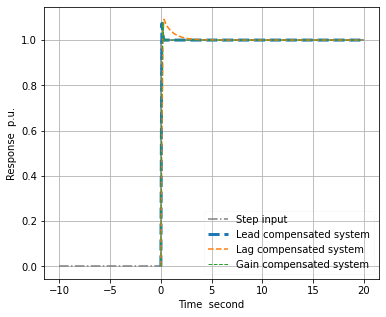

In [37]:
visualize_step({
    'Lead compensated system': matlab.feedback(G_c_G, 1),
    'Lag compensated system': matlab.feedback(G_without_gainK*K_Q2*G_c, 1),
    'Gain compensated system': matlab.feedback(G_without_gainK*MY_K, 1),
               })